In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report


In [6]:

df = pd.read_csv("NFL Play by Play 2009-2018 (v5).csv")


<ipython-input-6-2e6b0802d97c>:2: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("NFL Play by Play 2009-2018 (v5).csv")


In [7]:
# 3) Filter to passing plays and define X/y
pass_df = df[df['play_type'] == 'pass'].dropna(subset=[
    'quarter_seconds_remaining','down','ydstogo','yardline_100',
    'pass_length','pass_location','air_yards','yards_after_catch',
    'score_differential','qb_scramble','shotgun','no_huddle',
    'comp_air_epa','comp_yac_epa','pass_touchdown'
])

X = pass_df[[
    'quarter_seconds_remaining','down','ydstogo','yardline_100',
    'pass_length','pass_location','air_yards','yards_after_catch',
    'score_differential','qb_scramble','shotgun','no_huddle',
    'comp_air_epa','comp_yac_epa'
]]
y = pass_df['pass_touchdown']


In [8]:
# 4) Preprocessing pipeline
categorical_cols = ['pass_length', 'pass_location']
numeric_cols     = [c for c in X.columns if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(),             numeric_cols),
    ('cat', OneHotEncoder(drop='first'),  categorical_cols)
])

X_proc = preprocessor.fit_transform(X)


In [9]:
# 5) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_proc, y,
    test_size=0.20,
    random_state=513,
    stratify=y
)

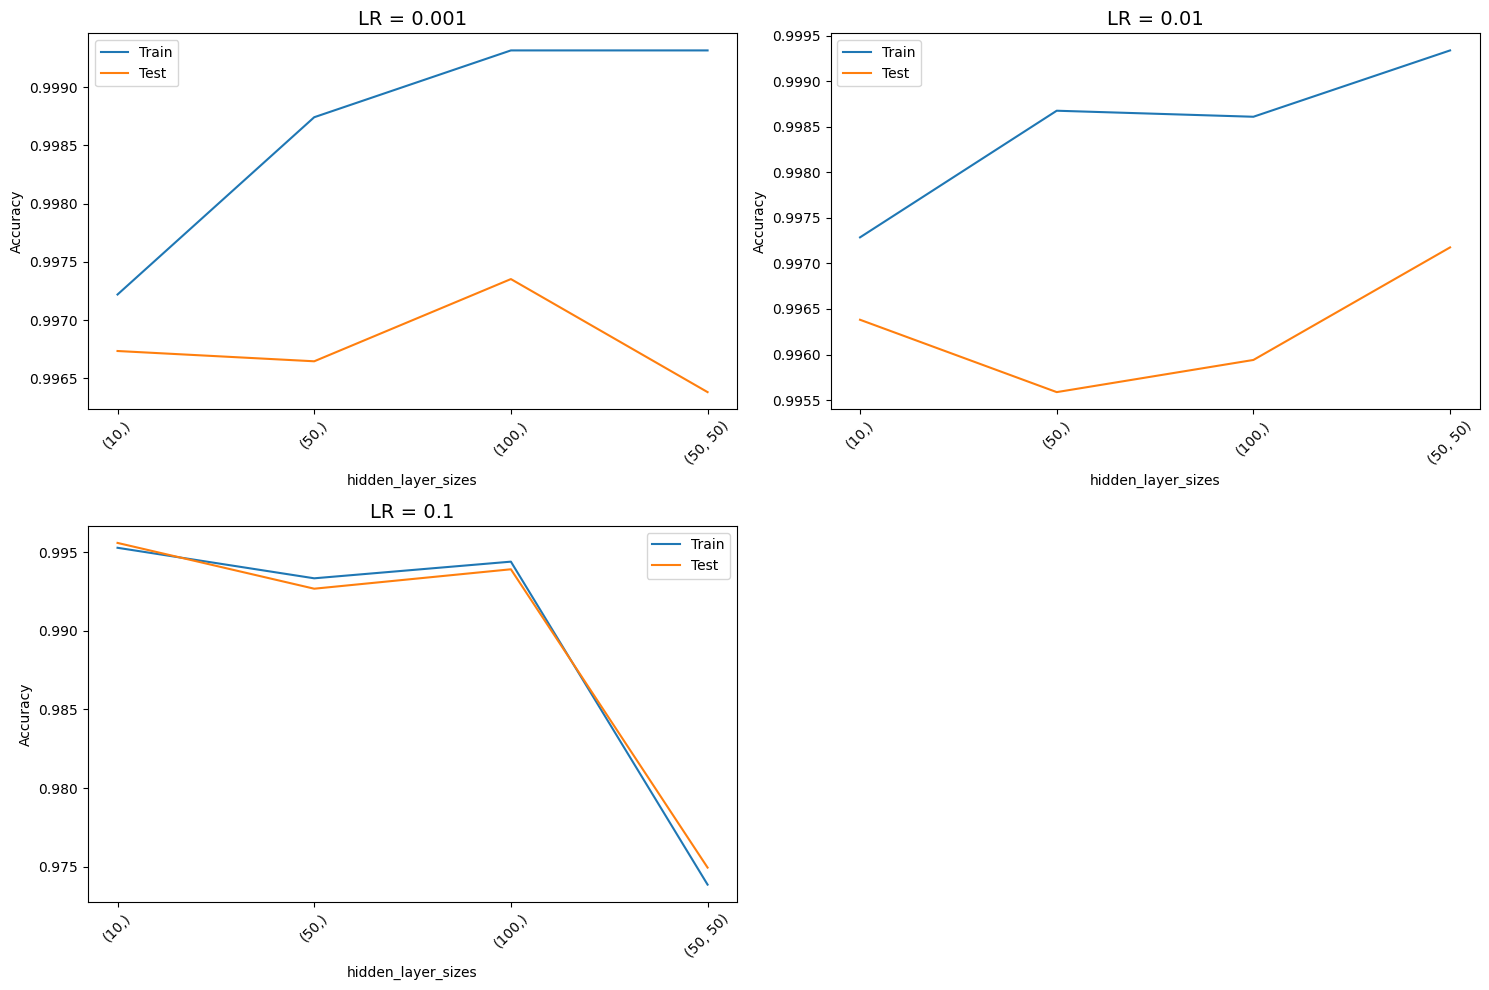

In [10]:
# 6) Hyperparameter exploration: varying hidden layer size and learning rate
hidden_sizes = [(10,), (50,), (100,), (50,50)]
lrates       = [0.001, 0.01, 0.1]

fig = plt.figure(figsize=(15, 10))
for i, lr in enumerate(lrates, 1):
    train_scores = []
    test_scores  = []
    for hs in hidden_sizes:
        mlp = MLPClassifier(hidden_layer_sizes=hs,
                            learning_rate_init=lr,
                            max_iter=200,
                            random_state=513)
        mlp.fit(X_train, y_train)
        train_scores.append(mlp.score(X_train, y_train))
        test_scores.append(mlp.score(X_test, y_test))

    ax = fig.add_subplot(2, 2, i)
    xs = range(len(hidden_sizes))
    ax.plot(xs, train_scores, label='Train')
    ax.plot(xs, test_scores,  label='Test')
    ax.set_title(f"LR = {lr}", size=14)
    ax.set_xticks(xs)
    ax.set_xticklabels([str(hs) for hs in hidden_sizes], rotation=45)
    ax.set_xlabel("hidden_layer_sizes")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


In [13]:
# 7) Train nn with chosen params

final_nn = MLPClassifier(
    hidden_layer_sizes=(50,50),
    learning_rate_init=0.01,
    max_iter=300,
    random_state=513
)
final_nn.fit(X_train, y_train)


MLPClassifier(hidden_layer_sizes=(50, 50), learning_rate_init=0.01,
              max_iter=300, random_state=513)

In [14]:
# 8) Evaluate
y_pred = final_nn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9971761383692199
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10525
         1.0       0.98      0.98      0.98       807

    accuracy                           1.00     11332
   macro avg       0.99      0.99      0.99     11332
weighted avg       1.00      1.00      1.00     11332



In [16]:
# 9) Prepare a new play
new_play = pd.DataFrame({
    'quarter_seconds_remaining': [893.0],
    'down':                      [1.0],
    'ydstogo':                   [10],
    'yardline_100':              [13.0],
    'pass_length':               ['short'],
    'pass_location':             ['left'],
    'air_yards':                 [15.0],
    'yards_after_catch':         [0.0],
    'score_differential':        [0.0],
    'qb_scramble':               [0],
    'shotgun':                   [0],
    'no_huddle':                 [0],
    'comp_air_epa':              [4.5212],
    'comp_yac_epa':              [0.0]
})

In [17]:
# 10) Transform & predict
X_new = preprocessor.transform(new_play)
print("Predicted pass touchdown (0=no, 1=yes):", final_nn.predict(X_new)[0])


Predicted pass touchdown (0=no, 1=yes): 1.0
